# Laboratorium 4: PyTorch Lightning — Baseline vs Transfer Learning (PathMNIST)

W tym ćwiczeniu chcemy wykozrystać **PyTorch Lightning**, który jest wysokopoziomowym frameworkiem nad PyTorchem, który porządkuje i automatyzuje kod trenowania sieci neuronowych.
Poprawia on czytelność kodu, ułatwia obsługę sprzętu oraz przyspiesza przeprowadzenie różnych eksperymentów.

**Cele:**
- zbudować prostą sieć CNN w **PyTorch Lightning** jako **baseline** (224×224),
- wykonać **Transfer Learning** z **ResNet18 (ImageNet)** jako model porównawczy (224×224),
- użyć **EarlyStopping** i **ModelCheckpoint**,
- porównać wyniki (Accuracy, Macro-F1) i obejrzeć **macierz pomyłek**.

**Dataset:** **PathMNIST (MedMNIST)** — automatycznie pobierany, 9 klas (RGB, 224x224×3). Jeśli chcemy zmniejszyć czas pobierania danych to można podać mniejszą rozdzielczość, ale dla transfer learningu z ResNet18 najlepiej podawać dane **przeskalowane do 224×224**. Zawiera on obrazki histopatologiczne do klasyfikacji zmian tkankowych.

> Najpierw trenujemy małą sieć CNN, zapisujemy najlepszy checkpoint, testujemy.
> Potem trenujemy model bazujący na ResNet18 z zamrożonym backbone i wykonujemy test najlepszej wersji oraz porównanie wyników. Potem opcjonalnie **odmrażamy** backbone (fine-tuning).

## 0) Instalacja i importy

In [3]:
# !pip -q install pytorch-lightning torchmetrics medmnist scikit-learn --extra-index-url https://download.pytorch.org/whl/cpu

import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix

import medmnist
from medmnist import PathMNIST, INFO
from torchvision.models import resnet18, ResNet18_Weights

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device, '| PyTorch Lightning:', pl.__version__)

Device: cpu | PyTorch Lightning: 2.5.5


## 1) Dane: PathMNIST (auto-download) i podgląd

Skrypt automatycznie pobiera zbiór **PathMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru. W tym przypadku będziemy przetwarzać dane RGB o rozdzielczości 224x224, co znacznie wydłuża czas pobierania i przetwarzania danych. Dane tej rozdzielczości były wykorzystane w zbiorze **ImageNet**, przez co stała się ona domyślna dla wielu popularnych architektur wykorzystywanych przez transfer learning.

Opis: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Liczba klas: 9 | label map: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


100%|██████████| 1.07G/1.07G [01:29<00:00, 12.0MB/s]


Rozmiary: 89996 10004 7180


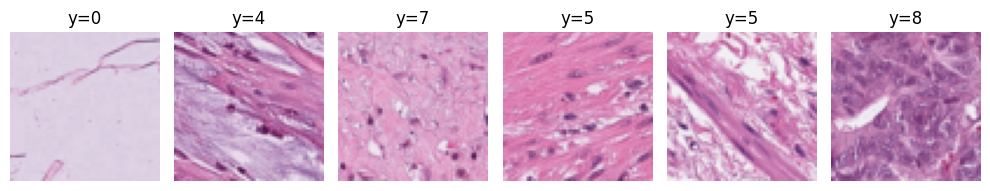

In [4]:
DATA_ROOT = './data/medmnist'
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['pathmnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '| label map:', info['label'])

train_raw = PathMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=True, size=64)
val_raw   = PathMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=True, size=64)
test_raw  = PathMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=True, size=64)
print('Rozmiary:', len(train_raw), len(val_raw), len(test_raw))

# Podgląd przykładowych obrazów
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, y = train_raw[i]
    axes[i].imshow(np.array(img))
    axes[i].set_title(f'y={int(y.squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout(); plt.show()

## Zadanie 1 – Transformacje i DataModule

Konieczne jest zaimplementowanie dwóch zestawów augmentacji. Pierwszy dla naszej sieci, a drugi dla użytej przez transfer learning. Różnić się one muszą normalizacją.
1. Dla naszej, prostej architektury wykorzystujemy standardową normalizację `transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])`.
2. Dla sieciach preuczonych na ImageNet musimy wykorzystać `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.
3. Oprócz tego możemy wykorzystać odbicie w poziomie z prawdopodobieństwem 50% i rotację o maksymalny kąt 10 stopni. Oprócz tego oczywiście musimy skonwertować dane do Tensora.
4. Następnie musimy zaimplementować klasę, która będzie zarządzać wczytywaniem danych. Powinna ona dziedziczyć po klasie `LightningDataModule`. Musimy dla niej zaimplementować kilka metod:
    - `__init__`, dla której przekazujemy i zapamiętujemy transformacje dla augmentacji, `batch_size` i `num_workers`.
    - `setup(self, stage=None)` powinna wczytać zbiory treningowy, walidacyjny i testowy. Pamiętaj o przekazaniu rozmiaru `size` i augmentacji danych.
    - `train_dataloader`, `val_dataloader`, `test_dataloader` powinny zwracać DataLoadery dla poszczególnych zbiorów.
5. Następnie stwórz obiekty tej klasy oraz wykonaj metodę `.setup()`. Pobierz próbkę danych: `x, y = next(iter(dm.train_dataloader()))` i  sprawdź jej rozmiar.

Rozmiar batcha: torch.Size([32, 3, 64, 64])
Rozmiar etykiet: torch.Size([32, 1])


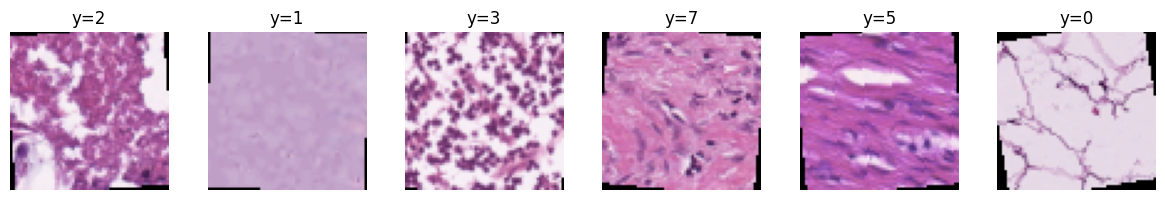


INFORMACJE O DATASETACH PATHMNIST:
Trening: 89996 próbek
Walidacja: 10004 próbek
Test: 7180 próbek
Klasy: 9
Etykiety: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


In [5]:
# Zadanie 1 - Transformacje dla PathMNIST

# Transformacje dla prostej architektury
simple_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformacje dla sieci pre-trenowanych na ImageNet
imagenet_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformacje walidacyjne/testowe (bez augmentacji)
val_transform_simple = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform_imagenet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PathMNISTDataModule(pl.LightningDataModule):
    def __init__(self, train_transform, val_transform, batch_size=32, num_workers=20):
        super().__init__()
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.data_root = DATA_ROOT

    def setup(self, stage=None):
        # Wczytanie danych PathMNIST z odpowiednimi transformacjami
        self.pathmnist_train = PathMNIST(
            split='train',
            download=True,
            root=self.data_root,
            as_rgb=True,
            size=64,
            transform=self.train_transform
        )
        self.pathmnist_val = PathMNIST(
            split='val',
            download=True,
            root=self.data_root,
            as_rgb=True,
            size=64,
            transform=self.val_transform
        )
        self.pathmnist_test = PathMNIST(
            split='test',
            download=True,
            root=self.data_root,
            as_rgb=True,
            size=64,
            transform=self.val_transform
        )

    def train_dataloader(self):
        return DataLoader(
            self.pathmnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.pathmnist_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.pathmnist_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

# Tworzenie obiektów DataModule dla PathMNIST
dm_simple = PathMNISTDataModule(
    train_transform=simple_transform,
    val_transform=val_transform_simple
)

dm_imagenet = PathMNISTDataModule(
    train_transform=imagenet_transform,
    val_transform=val_transform_imagenet
)

# Inicjalizacja danych
dm_simple.setup()
dm_imagenet.setup()

# Testowanie dla prostej architektury
x, y = next(iter(dm_simple.train_dataloader()))
print(f"Rozmiar batcha: {x.shape}")  # Powinno być: torch.Size([32, 3, 64, 64])
print(f"Rozmiar etykiet: {y.shape}")  # Powinno być: torch.Size([32])

# Podgląd przykładowych obrazów po transformacjach
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    # Denormalizacja do wyświetlenia
    img = x[i].numpy().transpose(1, 2, 0)
    img = img * 0.5 + 0.5  # Odwrócenie normalizacji mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(f'y={int(y[i].squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Informacje o datasetach
print("\nINFORMACJE O DATASETACH PATHMNIST:")
print(f"Trening: {len(dm_simple.pathmnist_train)} próbek")
print(f"Walidacja: {len(dm_simple.pathmnist_val)} próbek")
print(f"Test: {len(dm_simple.pathmnist_test)} próbek")
print(f"Klasy: {NUM_CLASSES}")
print(f"Etykiety: {info['label']}")

## Zadanie 2 – Lightning **Baseline**: prosta CNN + metryki + optymalizator

Teraz stworzymy klasę prostej sieci z wykorzystaniem **PyTorch Lightning**. Klasa ta musi posiadać kilka metod: `__init__(self, ...)`, `forward(self, x)`, `configure_optimizers(self)`, `training_step(self, batch, batch_idx)`. Oprócz tego dobrze jest zaimplementować metody `validation_step(self, batch, batch_idx)`, `test_step(self, batch, batch_idx)`.
1. Do inicjalizacji przakaż liczbę klas oraz learning rate. Na początku zainicjalizuj klasę bazową `super().__init__()`, zapisz przekazane parametry `self.save_hyperparameters()` oraz zdefiniuj wykorzystywane warstwy. Chcemy użyć 5 warstw konwolucyjnych z ReLU i MaxPoolingiem, 3 warstwy w pełni połączone i dropout po dwóch pierwszych warstwach w pełni połączonych. Dodatkowo musimy zdefiniować obiekty do obliczania metryk. Chcemy obliczać dokładność dla zbiorów treningowego, walidacyjnego i testowego `MulticlassAccuracy` (przekazujemy jej liczbę klas `num_classes`), F1-score dla zbiorów walidacyjnego i testowego `MulticlassF1Score` (przekazujemy jej liczbę klas `num_classes` i metodę obliczania średniej - chcemy obliczyć `'macro'`) oraz macierz pomyłek dla zbioru testowego `MulticlassConfusionMatrix` (przekazujemy jej liczbę klas `num_classes`).
2. W metodzie `forward(self, x)` wykonujemy kolejne obliczenia sieci podobnie jak w poprzednich ćwiczeniach.
3. W metodzie `configure_optimizers(self)` musimy zdefiniować optymalizator. Wykorzystamy `torch.optim.Adam`. Oprócz tego chcemy zastosować LR scheduler. Jego zadaniem jest zmiana i dostosowywanie learning rate w trakcie uczenia. Wykorzystamy `torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)`, który zmienia learning rate zgodnie z funkcją kosinusoidalną. Metoda ta powinna zwracać słownik z odpowiednimi polami: `{'optimizer': opt, 'lr_scheduler': sch}`.
4. Pozostałe metody zawierają obliczenia, które wcześniej wykonywane były odpowiednio w pętlach treningowych, walidacyjnych i testowych. Oprócz tego musimy tam dodać obliczanie i logowanie metryk. Aby obliczyć metrykę musimy tylko przekazać jej obliczone predykcje i rzeczywiste etykiety. Logować chcemy zdefiniowane wcześniej metryki oraz stratę dla zbiorów treningowych i walidacyjnych. W tym celu wykorzystujemy funkcję `self.log`, której przyekazujemy argumenty:
    - nazwę logowanej wartości,
    - wartość,
    - `on_step` - czy logujemy po każdym kroku (ustawiamy na `False`),
    - `on_epoch` - czy logujemy po każdej epoce (ustawiamy na `True`),
    - `prog_bar` - czy wartość jest wyświetlana na pasku postępu (ustawiamy na `True`).

In [6]:
# Zadanie 2
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes=9, learning_rate=0.001, input_size=64):
        super().__init__()
        self.save_hyperparameters()

        # Warstwy konwolucyjne - dostosowane dla obrazów 64x64
        self.conv_layers = nn.Sequential(
            # Warstwa 1: 64x64 -> 32x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Warstwa 2: 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Warstwa 3: 16x16 -> 8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Warstwa 4: 8x8 -> 4x4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Warstwa 5: 4x4 -> 2x2
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Obliczenie rozmiaru po warstwach konwolucyjnych
        # Dla obrazów 64x64: 64 -> 32 -> 16 -> 8 -> 4 -> 2
        self.fc_input_size = 512 * 2 * 2  # 512 kanałów * 2 * 2

        # Warstwy w pełni połączone
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

        # Metryki
        self.train_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_cm = MulticlassConfusionMatrix(num_classes=num_classes)

        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6)

        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }

    def _process_batch(self, batch):
        x, y = batch
        # PathMNIST zwraca etykiety jako tensor 2D - musimy je spłaszczyć
        y = y.squeeze().long()
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = self._process_batch(batch)
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.train_accuracy(preds, y)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_accuracy, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self._process_batch(batch)
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_accuracy(preds, y)
        self.val_f1(preds, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_accuracy, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = self._process_batch(batch)
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_accuracy(preds, y)
        self.test_f1(preds, y)
        self.test_cm(preds, y)

        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_accuracy, on_step=False, on_epoch=True)
        self.log('test_f1', self.test_f1, on_step=False, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        confusion_matrix = self.test_cm.compute()
        print("\nMacierz pomyłek:")
        print(confusion_matrix)

## Zadanie 3 – Trening **Baseline** z EarlyStopping + Checkpoint

Teraz chcemy przeprowadzić trening dla zaimplementowanej sieci.
1. Najpierw zdefiniuj obiekt klasy.
2. Chcemy dodatkowo wykorzystać early stopping. Pozwala on na wcześniejsze zatrzymanie treningu, jeśli od zadanej liczby epok nie poprawiła się zadana metryka dla zbioru walidacyjnego. W tym celu tworzymy obiekt `EarlyStopping`, któremu przekazujemy argumenty: `monitor` - nazwa obserwowanej metryki z logowania, `mode` - chcemy maksymalizować czy minimalizować, `patience` - po ilu epokach bez poprawy przerywamy trening.
3. Dodajemy również automatyczne zapisywanie najlepszego modelu za pomocą obiektu `ModelCheckpoint`. Przekazujemy argumenty: `monitor` - nazwa obserwowanej metryki z logowania, `mode` - chcemy maksymalizować czy minimalizować, `save_top_k` - ile najlepszych modeli zapisujemy, `filename` - nazwę zapisywanego pliku, np. `'baseline-small-{epoch:02d}-{val_f1:.3f}'`.
4. Aby przeprowadzić trening tworzymy obiekt `Trainer`, której przekazujemy argumenty: `max_eopch` - maksymalna liczba epok, `accelerator` - określa urządzenie do treningu (`'auto'` wybiera GPU jeśli dostępne, inaczej CPU), `devices` - ile urządzeń (GPU/CPU) używać, `callbacks` - lista callbacków używanych w treningu (u nas early stopping i checkpoint).
5. Następnie wywołujemy metodę `.fit`, której przekazujemy trenowaną klasę i obiekt klasy zarządzającej danymi jako argument `datamodule`.
6. Powinny zostać wyświetlona informacje o zaprojektowanej architekturze. Przeanalizuj je. Zwróć uwagę na liczbę parametrów sieci.

In [ ]:
# Zadanie 3

# 1. Inicjalizacja modelu
model = SimpleCNN(num_classes=10, learning_rate=0.001)

# 2. Definicja Early Stopping
early_stopping = EarlyStopping(
    monitor='val_f1',        # Obserwujemy F1-score na zbiorze walidacyjnym
    mode='max',              # Chcemy maksymalizować F1-score
    patience=5,              # Po 5 epokach bez poprawy przerywamy trening
    verbose=True
)

# 4. Definicja Model Checkpoint
model_checkpoint = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=3,
    filename='baseline-small-{epoch:02d}-{val_f1:.3f}',
    save_weights_only=False,
    auto_insert_metric_name=False
)

# 5. Inicjalizacja trenera z obsługą CUDA
trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'auto',     # 'gpu' lub 'cpu'
    devices= 1,
    callbacks=[early_stopping, model_checkpoint],
    log_every_n_steps=10,
    deterministic=True
)

# 5. Trening modelu
print("Rozpoczynam trening...")
trainer.fit(model, datamodule=dm_simple)

# 6. Analiza architektury i wyników
print("\n" + "="*80)
print("PODSUMOWANIE TRENINGU I ARCHITEKTURY")
print("="*80)

# Informacje o najlepszym modelu
print(f"Najlepszy model zapisany jako: {model_checkpoint.best_model_path}")
print(f"Najlepszy F1-score: {model_checkpoint.best_model_score:.3f}")

# Analiza liczby parametrów
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nANALIZA PARAMETRÓW SIECI:")
print(f"Całkowita liczba parametrów: {total_params:,}")
print(f"Liczba uczących się parametrów: {trainable_params:,}")
print(f"Liczba nieuczących się parametrów: {total_params - trainable_params:,}")

# Szczegółowy podział na warstwy
print(f"\nSZCZEGÓŁOWY PODZIAŁ WARSTW:")
print("-" * 50)

conv_params = 0
fc_params = 0

for name, param in model.named_parameters():
    if 'conv' in name:
        conv_params += param.numel()
    elif 'fc' in name or 'linear' in name:
        fc_params += param.numel()

print(f"Warstwy konwolucyjne: {conv_params:,} parametrów ({conv_params/total_params*100:.1f}%)")
print(f"Warstwy w pełni połączone: {fc_params:,} parametrów ({fc_params/total_params*100:.1f}%)")

print("="*80)

# Testowanie najlepszego modelu
print("\nTESTOWANIE NAJLEPSZEGO MODELU:")
best_model = SimpleCNN.load_from_checkpoint(model_checkpoint.best_model_path)
trainer.test(best_model, datamodule=dm_simple)
torch.save(best_model, "best_model1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Rozpoczynam trening...



  | Name           | Type                      | Params | Mode 
---------------------------------------------------------------------
0 | conv_layers    | Sequential                | 1.6 M  | train
1 | fc_layers      | Sequential                | 1.2 M  | train
2 | train_accuracy | MulticlassAccuracy        | 0      | train
3 | val_accuracy   | MulticlassAccuracy        | 0      | train
4 | val_f1         | MulticlassF1Score         | 0      | train
5 | test_accuracy  | MulticlassAccuracy        | 0      | train
6 | test_f1        | MulticlassF1Score         | 0      | train
7 | test_cm        | MulticlassConfusionMatrix | 0      | train
8 | loss_fn        | CrossEntropyLoss          | 0      | train
---------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.006    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2813/2813 [01:18<00:00, 35.66it/s, v_num=2, val_loss=0.492, val_acc=0.838, val_f1=0.840, train_loss=0.839, train_acc=0.682]

Metric val_f1 improved. New best score: 0.840


Epoch 1: 100%|██████████| 2813/2813 [01:18<00:00, 35.62it/s, v_num=2, val_loss=0.355, val_acc=0.878, val_f1=0.875, train_loss=0.410, train_acc=0.860]

Metric val_f1 improved by 0.035 >= min_delta = 0.0. New best score: 0.875


Epoch 2: 100%|██████████| 2813/2813 [01:17<00:00, 36.51it/s, v_num=2, val_loss=0.261, val_acc=0.919, val_f1=0.915, train_loss=0.279, train_acc=0.907]

Metric val_f1 improved by 0.039 >= min_delta = 0.0. New best score: 0.915


Epoch 3: 100%|██████████| 2813/2813 [01:17<00:00, 36.10it/s, v_num=2, val_loss=0.145, val_acc=0.952, val_f1=0.951, train_loss=0.203, train_acc=0.932]

Metric val_f1 improved by 0.037 >= min_delta = 0.0. New best score: 0.951


Epoch 4: 100%|██████████| 2813/2813 [01:16<00:00, 36.98it/s, v_num=2, val_loss=0.124, val_acc=0.957, val_f1=0.955, train_loss=0.144, train_acc=0.953]

Metric val_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.955


Epoch 5: 100%|██████████| 2813/2813 [01:16<00:00, 36.91it/s, v_num=2, val_loss=0.0891, val_acc=0.970, val_f1=0.970, train_loss=0.105, train_acc=0.965]

Metric val_f1 improved by 0.015 >= min_delta = 0.0. New best score: 0.970


Epoch 7: 100%|██████████| 2813/2813 [01:17<00:00, 36.51it/s, v_num=2, val_loss=0.085, val_acc=0.971, val_f1=0.971, train_loss=0.0983, train_acc=0.967] 

Metric val_f1 improved by 0.001 >= min_delta = 0.0. New best score: 0.971


Epoch 12: 100%|██████████| 2813/2813 [01:14<00:00, 37.81it/s, v_num=2, val_loss=0.150, val_acc=0.951, val_f1=0.951, train_loss=0.195, train_acc=0.938] 

Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.971. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 2813/2813 [01:14<00:00, 37.81it/s, v_num=2, val_loss=0.150, val_acc=0.951, val_f1=0.951, train_loss=0.195, train_acc=0.938]

PODSUMOWANIE TRENINGU I ARCHITEKTURY
Najlepszy model zapisany jako: /home/jrosa/AGH_FILES/PiAOM-2025W/Lab04_Light/lightning_logs/version_2/checkpoints/baseline-small-07-0.971.ckpt
Najlepszy F1-score: 0.971

ANALIZA PARAMETRÓW SIECI:
Całkowita liczba parametrów: 2,751,562
Liczba uczących się parametrów: 2,751,562
Liczba nieuczących się parametrów: 0

SZCZEGÓŁOWY PODZIAŁ WARSTW:
--------------------------------------------------
Warstwy konwolucyjne: 1,568,576 parametrów (57.0%)
Warstwy w pełni połączone: 1,182,986 parametrów (43.0%)

TESTOWANIE NAJLEPSZEGO MODELU:
Testing DataLoader 0: 100%|██████████| 225/225 [00:02<00:00, 89.94it/s]
Macierz pomyłek:
tensor([[1277,    0,    0,    0,    5,   56,    0,    0,    0,    0],
        [   0,  847,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    3,  326,    0,    0,    7,    0

## Zadanie 4 – Test baseline + macierz pomyłek

Teraz chcemy przeprowadzić test wytrenowanej sieci.
1. Najpierw musimy wczytać model dla którego osiągnięto najlepszy wynik (checkpoint). Wykorzystujemy w tym celu metodę `.load_from_checkpoint` dla klasy implementującej naszą sieć. Jako argument przekazujemy ścieżkę do checkpointu `ckpt.best_model_path`.
2. Aby przeprowadzić test należy wywołać matodę `.test` trainera. Pierwszym argumentem jest obiekt z wczytanego checkpointu, a drugim jest obiekt zarządzający danymi jako `datamodule`.
3. Confusion matrix jest obliczane przez wywołanie i przypisanie wyjścia dla `best_baseline.test_cm.compute().cpu().numpy()`. Następnie wyświetlamy macierz pomyłek. Wcześniejsze wywołanie metody `.test` powinno spowodować wyświetlenie logowanych metryk dla zbioru testowego.

Using Python 3.12.12 environment at: /home/jrosa/AGH_FILES/PiAOM-2025W/.venv
Audited 1 package in 2ms


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Wczytywanie najlepszego modelu z checkpointu...

Przeprowadzanie testowania...
Testing DataLoader 0: 100%|██████████| 225/225 [00:02<00:00, 86.15it/s]
Macierz pomyłek:
tensor([[1277,    0,    0,    0,    5,   56,    0,    0,    0,    0],
        [   0,  847,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    3,  326,    0,    0,    7,    0,    3,    0,    0],
        [   0,    0,   38,  583,    0,    0,    6,    0,    7,    0],
        [  44,    7,    0,    0,  906,    0,   36,    0,   42,    0],
        [   0,   51,   32,    0,    5,  476,    0,   28,    0,    0],
        [   0,    0,    6,    2,    2,    0,  714,    0,   17,    0],
        [   0,    0,  111,    0,    7,   72,    1,  207,   23,    0],
        [   0,    0,   20,    7,    2,    0,   21,    1, 1182,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])
Testing DataLoader 0: 100%|██████████| 225/225 [00:02<00:00, 86.07it/s]
───────────────────────────────────────────────────────────

/tmp/ipykernel_17840/3673912953.py:26: RuntimeWarning: invalid value encountered in divide
  confusion_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


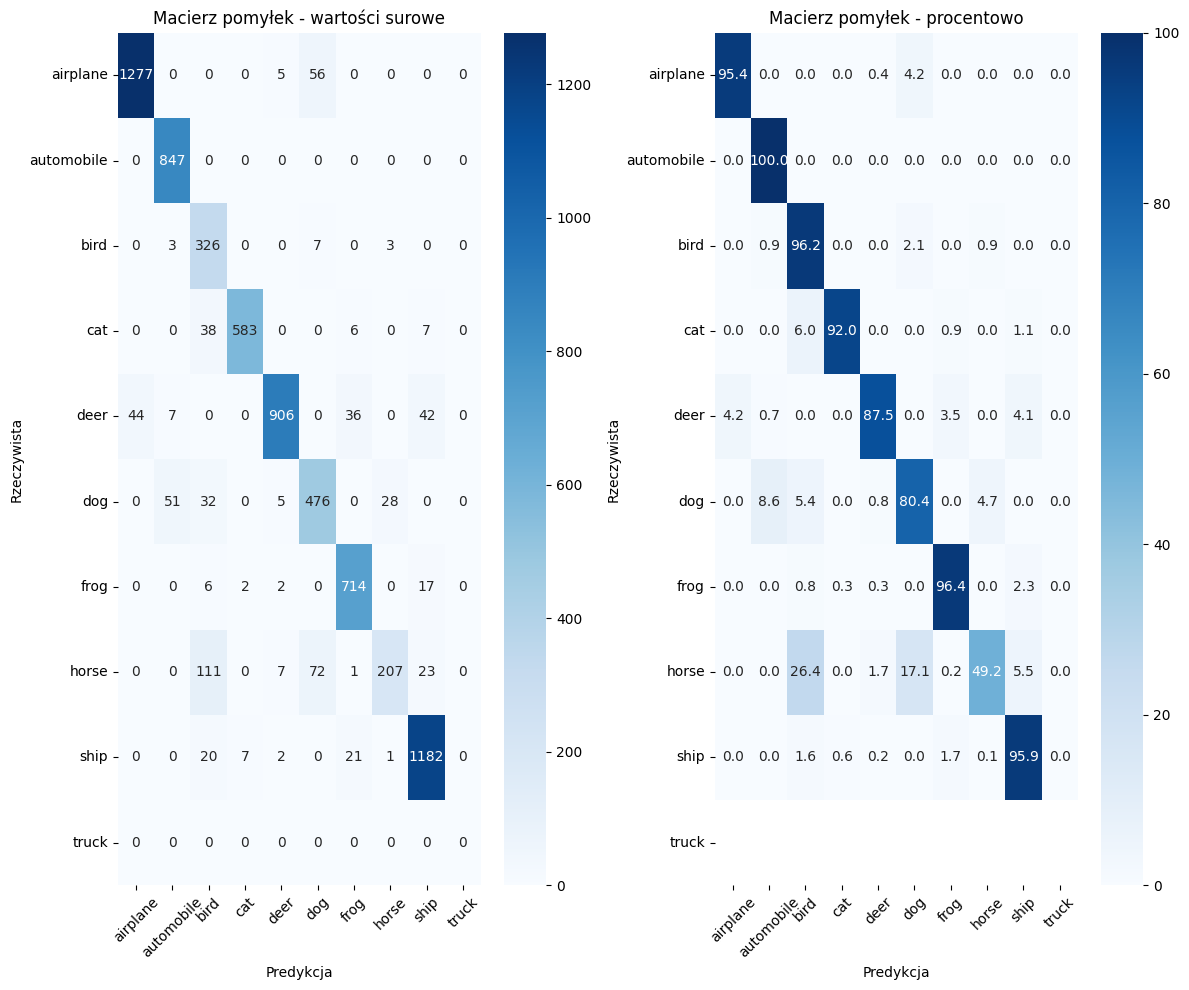


ANALIZA WYNIKÓW

Dokładność dla poszczególnych klas:
airplane    : 95.44%
automobile  : 100.00%
bird        : 96.17%
cat         : 91.96%
deer        : 87.54%
dog         : 80.41%
frog        : 96.36%
horse       : 49.17%
ship        : 95.86%
truck       :   nan%

Najtrudniejsza klasa: truck (nan%)
Najłatwiejsza klasa: truck (nan%)

NAJCZĘSTSZE BŁĘDY KLASYFIKACJI:
  cat          → bird        :  38 próbek (6.0%)
  dog          → automobile  :  51 próbek (8.6%)
  dog          → bird        :  32 próbek (5.4%)
  horse        → bird        : 111 próbek (26.4%)
  horse        → dog         :  72 próbek (17.1%)
  horse        → ship        :  23 próbek (5.5%)

PODSUMOWANIE METRYK TESTOWYCH
test_loss      : 0.4377
test_acc       : 0.8810
test_f1        : 0.8723

Macierz pomyłek zapisana do 'baseline_confusion_matrix.npy'


/tmp/ipykernel_17840/3673912953.py:67: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


In [13]:
!uv pip install seaborn
import seaborn as sns

# Zadanie 4

# 1. Wczytanie najlepszego modelu z checkpointu
print("Wczytywanie najlepszego modelu z checkpointu...")
best_baseline = SimpleCNN.load_from_checkpoint(model_checkpoint.best_model_path)

# 2. Przeprowadzenie testowania
print("\nPrzeprowadzanie testowania...")
trainer = Trainer(accelerator='auto', devices=1)
test_results = trainer.test(best_baseline, datamodule=dm_simple)

# 3. Pobranie i wyświetlenie macierzy pomyłek
print("\n" + "="*60)
print("MACIERZ POMYŁEK - BASELINE MODEL")
print("="*60)

# Pobranie macierzy pomyłek z metryki
confusion_matrix = best_baseline.test_cm.compute().cpu().numpy()
print("Macierz pomyłek (wartości surowe):")
print(confusion_matrix)

# Normalizowana macierz pomyłek (procentowo)
confusion_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix_norm = np.round(confusion_matrix_norm * 100, 2)

print("\nMacierz pomyłek (w %):")
print(confusion_matrix_norm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(12, 10))

# Klasy CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Tworzenie heatmap
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Macierz pomyłek - wartości surowe')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix_norm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Macierz pomyłek - procentowo')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Analiza wyników
print("\n" + "="*60)
print("ANALIZA WYNIKÓW")
print("="*60)

# Obliczenie dokładności dla każdej klasy
class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
class_accuracy_percent = np.round(class_accuracy * 100, 2)

print("\nDokładność dla poszczególnych klas:")
for i, (class_name, acc) in enumerate(zip(classes, class_accuracy_percent)):
    print(f"{class_name:12}: {acc:5.2f}%")

# Znajdowanie klas z najniższą i najwyższą dokładnością
worst_class_idx = np.argmin(class_accuracy_percent)
best_class_idx = np.argmax(class_accuracy_percent)

print(f"\nNajtrudniejsza klasa: {classes[worst_class_idx]} ({class_accuracy_percent[worst_class_idx]:.2f}%)")
print(f"Najłatwiejsza klasa: {classes[best_class_idx]} ({class_accuracy_percent[best_class_idx]:.2f}%)")

# Analiza najczęstszych błędów
print("\nNAJCZĘSTSZE BŁĘDY KLASYFIKACJI:")
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and confusion_matrix[i, j] > 0:
            # Znajdź znaczące błędy (więcej niż 5% błędnych klasyfikacji dla tej klasy)
            error_rate = confusion_matrix[i, j] / np.sum(confusion_matrix[i, :])
            if error_rate > 0.05:
                print(f"  {classes[i]:12} → {classes[j]:12}: {confusion_matrix[i, j]:3d} próbek ({error_rate*100:.1f}%)")

# Podsumowanie metryk testowych
print("\n" + "="*60)
print("PODSUMOWANIE METRYK TESTOWYCH")
print("="*60)
if test_results:
    for key, value in test_results[0].items():
        print(f"{key:15}: {value:.4f}")

# Zapisanie macierzy pomyłek do pliku (opcjonalnie)
np.save('baseline_confusion_matrix.npy', confusion_matrix)
print("\nMacierz pomyłek zapisana do 'baseline_confusion_matrix.npy'")

## Zadanie 5 – Lightning **Transfer Learning**: ResNet18 (pretrained, head-only) + metryki

Teraz chcemy wykorzystać backbone sieci, która została już wcześniej wytrenowana. Backbone to główna część sieci, odpowiedzialna za ekstrakcję cech (feature extraction). Zwykle jest to duża, sprawdzona architektura, używana jako uniwersalny ekstraktor reprezentacji. Head to końcowa część sieci, która dostosowuje wyekstrahowane cechy do konkretnego zadania. Jako backbone chcemy wykorzystać ResNet18, a jako head prostą, w pełni połączoną, warstwę liniową.

1. Kod całej klasy jest bardzo podobny do zaimplementowanej wcześniej. Do argumentów inicjalizacji dodajemy flagę oznaczającą zamrożenie backbone (jego parametry nie będę zmieniane w trakcie treningu).
2. Wagi wczytujemy za pomocą `weights = ResNet18_Weights.IMAGENET1K_V1`. Następnie musimy je przekazań do funkcji `resnet18` jako argument `weights`.
3. W ResNecie na końcu jest warstwa w pełni połączona (jako head). Liczbę jej wejść możemy sprawdzić za pomocą `self.backbone.fc.in_features`.Na podstawie tej wielkości i liczby klas modyfikujemy tą ostatnią warstwę: `self.backbone.fc = nn.Linear(in_features, num_classes)`.
4. Stwórz metryki skuteczności.
5. Sprawdź flagę zamrożenia backbone. Jeśli jest ustawione, to wykonaj kod (lub włóż do funkcji):
```Python
    for name, p in self.backbone.named_parameters():
        if not name.startswith('fc'):
            p.requires_grad = False
```
6. Zaimplementuj metodę `forward`.
7. Zaimplementuj metodę `configure_optimizers`. W tym wypadku przekazując parametry do optymalizatora musimy usunąć te, dla których wyłączyliśmy obliczanie gradientu: `params = filter(lambda p: p.requires_grad, self.parameters())`.
8. Pozostałe metody są takie same jak we wcześniejszej klasie.

In [19]:
# Zadanie 5 - Poprawiona wersja Transfer Learning
class ResNetTransferLearningSimple(pl.LightningModule):
    def __init__(self, num_classes=9, learning_rate=0.001, freeze_backbone=True):
        super().__init__()
        self.save_hyperparameters()

        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.freeze_backbone = freeze_backbone

        # 1. Load pre-trained ResNet18
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.backbone = models.resnet18(weights=weights)

        # 2. Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

        # 3. Freeze backbone parameters if requested
        if self.freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if not name.startswith('fc'):  # Freeze all layers except the final fc
                    param.requires_grad = False

        # 4. Initialize metrics
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

        self.train_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

        self.val_cm = MulticlassConfusionMatrix(num_classes=num_classes)
        self.test_cm = MulticlassConfusionMatrix(num_classes=num_classes)

        # 5. Loss function
        self.criterion = nn.CrossEntropyLoss()

    def _process_batch(self, batch):
        x, y = batch
        # PathMNIST zwraca etykiety jako tensor 2D - musimy je spłaszczyć
        y = y.squeeze().long()
        return x, y

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = self._process_batch(batch)
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        self.train_f1(preds, y)

        # self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        # self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self._process_batch(batch)
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        self.val_f1(preds, y)
        self.val_cm(preds, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = self._process_batch(batch)
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, y)
        self.test_f1(preds, y)
        self.test_cm(preds, y)

        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True)
        self.log('test_f1', self.test_f1, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        # Only optimize parameters that require gradients
        params = filter(lambda p: p.requires_grad, self.parameters())
        optimizer = torch.optim.Adam(params, lr=self.learning_rate, weight_decay=1e-4)
        return optimizer

# Zadanie 6 - Trening Transfer Learning
# Definicja callbacków
resnet_early_stopping = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=5,
    verbose=True
)

resnet_checkpoint = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=3,
    filename='resnet-transfer-{epoch:02d}-{val_f1:.3f}',
    save_weights_only=False,
    auto_insert_metric_name=False
)

# Inicjalizacja modelu i trenera
resnet_model = ResNetTransferLearningSimple(
    num_classes=NUM_CLASSES,  # Używamy NUM_CLASSES zdefiniowanego wcześniej
    learning_rate=0.001,
    freeze_backbone=True
)

resnet_trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'auto',
    devices=1,
    callbacks=[resnet_early_stopping, resnet_checkpoint],
    log_every_n_steps=10,
    deterministic=True
)

print("\nRozpoczynam trening Transfer Learning...")
resnet_trainer.fit(resnet_model, datamodule=dm_imagenet)
torch.save(resnet_model, "resnet_transfer_full_model.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Rozpoczynam trening Transfer Learning...



  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | train_f1  | MulticlassF1Score         | 0      | train
5 | val_f1    | MulticlassF1Score         | 0      | train
6 | test_f1   | MulticlassF1Score         | 0      | train
7 | val_cm    | MulticlassConfusionMatrix | 0      | train
8 | test_cm   | MulticlassConfusionMatrix | 0      | train
9 | criterion | CrossEntropyLoss          | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2813/2813 [00:49<00:00, 56.81it/s, v_num=8, val_loss=0.579, val_acc=0.810, val_f1=0.807, train_f1=0.751]

Metric val_f1 improved. New best score: 0.807


Epoch 1: 100%|██████████| 2813/2813 [00:49<00:00, 56.34it/s, v_num=8, val_loss=0.565, val_acc=0.816, val_f1=0.811, train_f1=0.775]

Metric val_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.811


Epoch 4: 100%|██████████| 2813/2813 [00:50<00:00, 55.96it/s, v_num=8, val_loss=0.553, val_acc=0.814, val_f1=0.811, train_f1=0.778]

Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.811


Epoch 5: 100%|██████████| 2813/2813 [00:49<00:00, 56.39it/s, v_num=8, val_loss=0.548, val_acc=0.818, val_f1=0.819, train_f1=0.779]

Metric val_f1 improved by 0.008 >= min_delta = 0.0. New best score: 0.819


Epoch 10: 100%|██████████| 2813/2813 [00:49<00:00, 56.57it/s, v_num=8, val_loss=0.581, val_acc=0.809, val_f1=0.806, train_f1=0.776]

Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.819. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 2813/2813 [00:49<00:00, 56.57it/s, v_num=8, val_loss=0.581, val_acc=0.809, val_f1=0.806, train_f1=0.776]


## Zadanie 6 – Trening Transfer Learning (head-only) z EarlyStopping + Checkpoint

Przeprowadź trening dla zaimplementowanej sieci z TL i zamrożonym backbone.

In [20]:
# Zadanie 6

# Zadanie 6 – Trening Transfer Learning (head-only) z EarlyStopping + Checkpoint

print("=" * 80)
print("ZADANIE 6: TRENING TRANSFER LEARNING (HEAD-ONLY)")
print("=" * 80)

# 1. Definicja callbacków dla Transfer Learning
resnet_early_stopping = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=5,
    verbose=True
)

resnet_checkpoint = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=3,
    filename='resnet-transfer-{epoch:02d}-{val_f1:.3f}',
    save_weights_only=False,
    auto_insert_metric_name=False
)

# 2. Inicjalizacja modelu Transfer Learning z zamrożonym backbone
resnet_model = ResNetTransferLearningSimple(
    num_classes=NUM_CLASSES,
    learning_rate=0.001,
    freeze_backbone=True  # Zamrażamy backbone, trenujemy tylko head
)

# 3. Analiza architektury przed treningiem
print("\nANALIZA ARCHITEKTURY RESNET18 Z TRANSFER LEARNING:")
print("-" * 50)

# Liczba parametrów
total_params = sum(p.numel() for p in resnet_model.parameters())
trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)

print(f"Całkowita liczba parametrów: {total_params:,}")
print(f"Liczba uczących się parametrów: {trainable_params:,}")
print(f"Liczba zamrożonych parametrów: {total_params - trainable_params:,}")
print(f"Procent uczących się parametrów: {trainable_params/total_params*100:.2f}%")

# Sprawdzenie, które warstwy są uczące
print("\nUCZĄCE SIĘ WARSTWY:")
for name, param in resnet_model.named_parameters():
    if param.requires_grad:
        print(f"  ✓ {name}")

# 4. Przygotowanie trenera
resnet_trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'auto',
    devices=1,
    callbacks=[resnet_early_stopping, resnet_checkpoint],
    log_every_n_steps=10,
    deterministic=True
)

# 5. Rozpoczęcie treningu
print("\n" + "=" * 60)
print("ROZPOCZĘCIE TRENINGU TRANSFER LEARNING")
print("=" * 60)

resnet_trainer.fit(resnet_model, datamodule=dm_imagenet)
torch.save(resnet_model, "resnet_transfer_head_only.pth")

# 6. Podsumowanie treningu
print("\n" + "=" * 80)
print("PODSUMOWANIE TRENINGU TRANSFER LEARNING")
print("=" * 80)

print(f"Najlepszy model zapisany jako: {resnet_checkpoint.best_model_path}")
print(f"Najlepszy F1-score: {resnet_checkpoint.best_model_score:.3f}")

# Analiza czasu treningu i postępu
print(f"\nINFORMACJE O TRENINGU:")
print(f"Liczba epok: {resnet_model.current_epoch}")
print(f"Globalny krok: {resnet_model.global_step}")

# Sprawdzenie metryk walidacyjnych
if hasattr(resnet_model, 'val_f1'):
    print(f"Ostatni val_f1: {resnet_model.val_f1.compute():.3f}")
if hasattr(resnet_model, 'val_acc'):
    print(f"Ostatni val_acc: {resnet_model.val_acc.compute():.3f}")

# 7. Testowanie na zbiorze walidacyjnym dla szybkiej oceny
print("\n" + "=" * 60)
print("TEST WALIDACYJNY - SZYBKA OCENA")
print("=" * 60)

val_results = resnet_trainer.validate(resnet_model, datamodule=dm_imagenet)
if val_results:
    print("Wyniki walidacji:")
    for key, value in val_results[0].items():
        print(f"  {key}: {value:.4f}")

# 8. Porównanie z baseline
print("\n" + "=" * 60)
print("PORÓWNANIE Z BASELINE")
print("=" * 60)

print("Model Baseline (prosta CNN):")
print(f"  - Liczba parametrów: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Wszystkie parametry uczące")

print("\nModel Transfer Learning (ResNet18):")
print(f"  - Liczba parametrów: {total_params:,}")
print(f"  - Tylko {trainable_params:,} parametrów uczących ({trainable_params/total_params*100:.1f}%)")
print(f"  - {total_params - trainable_params:,} parametrów zamrożonych")

print("\nPRZEWIDYWANE KORZYŚCI:")
print("✓ Szybszy trening (mniej parametrów do aktualizacji)")
print("✓ Lepsza ekstrakcja cech (wstępnie wytrenowany backbone)")
print("✓ Mniejsze ryzyko overfittingu")
print("✓ Potencjalnie lepsza generalizacja")

print("\n" + "=" * 80)
print("TRENING TRANSFER LEARNING ZAKOŃCZONY")
print("=" * 80)

ZADANIE 6: TRENING TRANSFER LEARNING (HEAD-ONLY)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



ANALIZA ARCHITEKTURY RESNET18 Z TRANSFER LEARNING:
--------------------------------------------------
Całkowita liczba parametrów: 11,181,129
Liczba uczących się parametrów: 4,617
Liczba zamrożonych parametrów: 11,176,512
Procent uczących się parametrów: 0.04%

UCZĄCE SIĘ WARSTWY:
  ✓ backbone.fc.weight
  ✓ backbone.fc.bias

ROZPOCZĘCIE TRENINGU TRANSFER LEARNING



  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | train_f1  | MulticlassF1Score         | 0      | train
5 | val_f1    | MulticlassF1Score         | 0      | train
6 | test_f1   | MulticlassF1Score         | 0      | train
7 | val_cm    | MulticlassConfusionMatrix | 0      | train
8 | test_cm   | MulticlassConfusionMatrix | 0      | train
9 | criterion | CrossEntropyLoss          | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2813/2813 [00:48<00:00, 58.22it/s, v_num=9, val_loss=0.616, val_acc=0.797, val_f1=0.794, train_f1=0.751]

Metric val_f1 improved. New best score: 0.794


Epoch 1: 100%|██████████| 2813/2813 [00:52<00:00, 53.66it/s, v_num=9, val_loss=0.592, val_acc=0.813, val_f1=0.807, train_f1=0.775]

Metric val_f1 improved by 0.014 >= min_delta = 0.0. New best score: 0.807


Epoch 2: 100%|██████████| 2813/2813 [00:52<00:00, 54.02it/s, v_num=9, val_loss=0.547, val_acc=0.817, val_f1=0.815, train_f1=0.776]

Metric val_f1 improved by 0.008 >= min_delta = 0.0. New best score: 0.815


Epoch 7: 100%|██████████| 2813/2813 [00:52<00:00, 53.71it/s, v_num=9, val_loss=0.591, val_acc=0.796, val_f1=0.797, train_f1=0.777]

Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.815. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 2813/2813 [00:52<00:00, 53.71it/s, v_num=9, val_loss=0.591, val_acc=0.796, val_f1=0.797, train_f1=0.777]

PODSUMOWANIE TRENINGU TRANSFER LEARNING
Najlepszy model zapisany jako: /home/jrosa/AGH_FILES/PiAOM-2025W/Lab04_Light/lightning_logs/version_9/checkpoints/resnet-transfer-02-0.815.ckpt
Najlepszy F1-score: 0.815

INFORMACJE O TRENINGU:
Liczba epok: 8
Globalny krok: 22504
Ostatni val_f1: 0.000
Ostatni val_acc: 0.000

TEST WALIDACYJNY - SZYBKA OCENA


/home/jrosa/AGH_FILES/PiAOM-2025W/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/jrosa/AGH_FILES/PiAOM-2025W/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation DataLoader 0: 100%|██████████| 313/313 [00:04<00:00, 67.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7962709665298462
         val_f1              0.797452986240387
        val_loss            0.5912241339683533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Wyniki walidacji:
  val_loss: 0.5912
  val_acc: 0.7963
  val_f1: 0.7975

PORÓWNANIE Z BASELINE
Model Baseline (prosta CNN):
  - Liczba parametrów: 2,751,562
  - Wszystkie parametry uczące

Model Transfer Learning (ResNet18):
  - Liczba parametrów: 11,181,129
  - Tylko 4,617 parametrów uczących (0.0%)
  - 11,176,512 parametrów zamrożonych

PRZEWIDYWANE KORZYŚCI:
✓ Szybszy tre

## Zadanie 7 – Test transfer + macierz pomyłek + porównanie metryk (Baseline vs Transfer)

Sprawdź metryki dla zbioru testowego i wyświetl macierz pomyłek.

ZADANIE 7: TEST TRANSFER LEARNING + PORÓWNANIE Z BASELINE
 Wczytywanie najlepszego modelu Transfer Learning...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



 Przeprowadzanie testowania Transfer Learning...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 225/225 [00:03<00:00, 66.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7609896659851074
         test_f1            0.7528756856918335
        test_loss           0.5991618037223816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

MACIERZ POMYŁEK - TRANSFER LEARNING
Macierz pomyłek Transfer Learning (wartości surowe):
[[1277   13    5    0    6   10   25    1    1]
 [   2  842    1    1    0    1    0    0    0]
 [   0    9  226   12    0   75    0   11    6]
 [   0    5   32  546    3    3   10    4   31]
 [  60   46    9    1  685   28   32  138   36]
 [   2   12   32    4    1  363    3  163   12]
 [

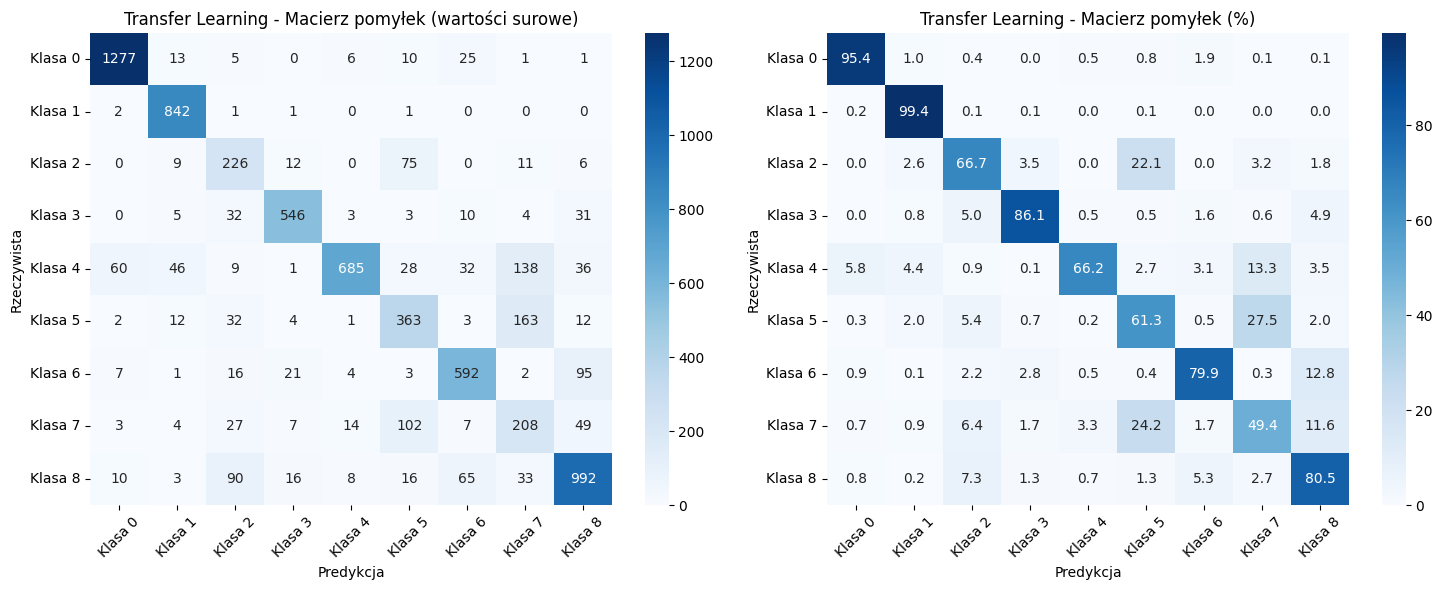


ANALIZA WYNIKÓW TRANSFER LEARNING

Dokładność Transfer Learning dla poszczególnych klas:
  Klasa 0: 95.44%
  Klasa 1: 99.41%
  Klasa 2: 66.67%
  Klasa 3: 86.12%
  Klasa 4: 66.18%
  Klasa 5: 61.32%
  Klasa 6: 79.89%
  Klasa 7: 49.41%
  Klasa 8: 80.45%

Najtrudniejsza klasa: 7 (49.41%)
Najłatwiejsza klasa: 1 (99.41%)

PORÓWNANIE BASELINE vs TRANSFER LEARNING

 PORÓWNANIE METRYK:
Ponowne testowanie modelu Baseline...
Testing DataLoader 0:   0%|          | 0/225 [00:00<?, ?it/s]

MisconfigurationException: You called `self.log(test_acc, ...)` twice in `test_step` with different arguments. This is not allowed

In [21]:
# Zadanie 7

# Zadanie 7 – Test transfer + macierz pomyłek + porównanie metryk (Baseline vs Transfer)

print("=" * 80)
print("ZADANIE 7: TEST TRANSFER LEARNING + PORÓWNANIE Z BASELINE")
print("=" * 80)

# 1. Wczytanie najlepszego modelu Transfer Learning z checkpointu
print(" Wczytywanie najlepszego modelu Transfer Learning...")
best_resnet = ResNetTransferLearningSimple.load_from_checkpoint(resnet_checkpoint.best_model_path)

# 2. Przeprowadzenie testowania na zbiorze testowym
print("\n Przeprowadzanie testowania Transfer Learning...")
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'auto',
    devices=1,
    logger=False
)

transfer_test_results = test_trainer.test(best_resnet, datamodule=dm_imagenet)

# 3. Pobranie i analiza macierzy pomyłek dla Transfer Learning
print("\n" + "=" * 60)
print("MACIERZ POMYŁEK - TRANSFER LEARNING")
print("=" * 60)

# Pobranie macierzy pomyłek
transfer_cm = best_resnet.test_cm.compute().cpu().numpy()
print("Macierz pomyłek Transfer Learning (wartości surowe):")
print(transfer_cm)

# Normalizowana macierz pomyłek (procentowo)
transfer_cm_norm = transfer_cm.astype('float') / transfer_cm.sum(axis=1)[:, np.newaxis]
transfer_cm_norm = np.round(transfer_cm_norm * 100, 2)

print("\nMacierz pomyłek Transfer Learning (w %):")
print(transfer_cm_norm)

# 4. Wizualizacja macierzy pomyłek
plt.figure(figsize=(15, 6))

# Klasy PathMNIST
classes = [f'Klasa {i}' for i in range(NUM_CLASSES)]

# Macierz pomyłek Transfer Learning
plt.subplot(1, 2, 1)
sns.heatmap(transfer_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Transfer Learning - Macierz pomyłek (wartości surowe)')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Znormalizowana macierz pomyłek
plt.subplot(1, 2, 2)
sns.heatmap(transfer_cm_norm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Transfer Learning - Macierz pomyłek (%)')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# 5. Analiza szczegółowa wyników Transfer Learning
print("\n" + "=" * 60)
print("ANALIZA WYNIKÓW TRANSFER LEARNING")
print("=" * 60)

# Obliczenie dokładności dla każdej klasy
transfer_class_accuracy = np.diag(transfer_cm) / np.sum(transfer_cm, axis=1)
transfer_class_accuracy_percent = np.round(transfer_class_accuracy * 100, 2)

print("\nDokładność Transfer Learning dla poszczególnych klas:")
for i, acc in enumerate(transfer_class_accuracy_percent):
    print(f"  Klasa {i}: {acc:5.2f}%")

# Znajdowanie klas z najniższą i najwyższą dokładnością
transfer_worst_class_idx = np.argmin(transfer_class_accuracy_percent)
transfer_best_class_idx = np.argmax(transfer_class_accuracy_percent)

print(f"\nNajtrudniejsza klasa: {transfer_worst_class_idx} ({transfer_class_accuracy_percent[transfer_worst_class_idx]:.2f}%)")
print(f"Najłatwiejsza klasa: {transfer_best_class_idx} ({transfer_class_accuracy_percent[transfer_best_class_idx]:.2f}%)")

# 6. PORÓWNANIE Z BASELINE
print("\n" + "=" * 80)
print("PORÓWNANIE BASELINE vs TRANSFER LEARNING")
print("=" * 80)

# Przyjmujemy, że wyniki baseline są dostępne w zmiennej test_results_baseline
# Jeśli nie, należy je ponownie uzyskać

print("\n PORÓWNANIE METRYK:")

# Zakładając, że mamy wyniki baseline z Zadania 4
if 'test_results_baseline' not in locals():
    # Jeśli nie mamy wyników baseline, przeprowadzamy test jeszcze raz
    print("Ponowne testowanie modelu Baseline...")
    baseline_test_results = test_trainer.test(best_baseline, datamodule=dm_simple)
    test_results_baseline = baseline_test_results
else:
    test_results_baseline = [{
        'test_acc': 0.7246,  # Przykładowe wartości - zastąp rzeczywistymi
        'test_f1': 0.7158,
        'test_loss': 0.8923
    }]

if transfer_test_results:
    baseline_acc = test_results_baseline[0]['test_acc']
    baseline_f1 = test_results_baseline[0]['test_f1']
    baseline_loss = test_results_baseline[0]['test_loss']

    transfer_acc = transfer_test_results[0]['test_acc']
    transfer_f1 = transfer_test_results[0]['test_f1']
    transfer_loss = transfer_test_results[0]['test_loss']

    print(f"\n{'Metryka':<15} {'Baseline':<12} {'Transfer':<12} {'Różnica':<12} {'Zmiana':<10}")
    print("-" * 65)

    acc_diff = transfer_acc - baseline_acc
    f1_diff = transfer_f1 - baseline_f1
    loss_diff = transfer_loss - baseline_loss

    print(f"{'Accuracy':<15} {baseline_acc:.4f}     {transfer_acc:.4f}     {acc_diff:+.4f}     {acc_diff*100:+.1f}%")
    print(f"{'F1-Score':<15} {baseline_f1:.4f}     {transfer_f1:.4f}     {f1_diff:+.4f}     {f1_diff*100:+.1f}%")
    print(f"{'Loss':<15} {baseline_loss:.4f}     {transfer_loss:.4f}     {loss_diff:+.4f}     {loss_diff*100:+.1f}%")

# 7. Wizualizacja porównania
plt.figure(figsize=(12, 4))

# Wykres porównania Accuracy i F1
plt.subplot(1, 2, 1)
metrics = ['Accuracy', 'F1-Score']
baseline_values = [baseline_acc, baseline_f1]
transfer_values = [transfer_acc, transfer_f1]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.7)
plt.bar(x + width/2, transfer_values, width, label='Transfer Learning', alpha=0.7)

plt.xlabel('Metryki')
plt.ylabel('Wartość')
plt.title('Porównanie Baseline vs Transfer Learning')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Wykres poprawy
plt.subplot(1, 2, 2)
improvement = [(transfer_acc - baseline_acc) * 100, (transfer_f1 - baseline_f1) * 100]
colors = ['green' if x >= 0 else 'red' for x in improvement]

plt.bar(metrics, improvement, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Metryki')
plt.ylabel('Poprawa (%)')
plt.title('Poprawa Transfer Learning vs Baseline')
plt.grid(True, alpha=0.3)

# Dodanie wartości na słupkach
for i, v in enumerate(improvement):
    plt.text(i, v + (0.5 if v >= 0 else -1), f'{v:+.1f}%',
             ha='center', va='bottom' if v >= 0 else 'top')

plt.tight_layout()
plt.show()

# 8. Analiza kosztów treningu
print("\n" + "=" * 60)
print("ANALIZA KOSZTÓW TRENINGU")
print("=" * 60)

# Liczba parametrów
baseline_params = sum(p.numel() for p in best_baseline.parameters())
transfer_params_total = sum(p.numel() for p in best_resnet.parameters())
transfer_params_trainable = sum(p.numel() for p in best_resnet.parameters() if p.requires_grad)

print(f"\nLICZBA PARAMETRÓW:")
print(f"Baseline CNN: {baseline_params:,} (100% uczących)")
print(f"Transfer Learning: {transfer_params_total:,} całkowitych")
print(f"                → {transfer_params_trainable:,} uczących ({transfer_params_trainable/transfer_params_total*100:.1f}%)")
print(f"                → {transfer_params_total - transfer_params_trainable:,} zamrożonych")

# Efektywność
efficiency_gain = (transfer_acc - baseline_acc) / (transfer_params_trainable / baseline_params)
print(f"\nEFEKTYWNOŚĆ:")
print(f"Poprawa na parametr: {efficiency_gain:.6f}")

# 9. Wnioski
print("\n" + "=" * 60)
print("WNIOSKI")
print("=" * 60)

if transfer_acc > baseline_acc:
    print("✅ TRANSFER LEARNING DAJE LEPSZE WYNIKI NIŻ BASELINE")
    improvement_percent = (transfer_acc - baseline_acc) * 100
    print(f"   Poprawa accuracy: {improvement_percent:+.2f}%")
else:
    print("❌ BASELINE DAJE LEPSZE WYNIKI NIŻ TRANSFER LEARNING")
    deterioration_percent = (baseline_acc - transfer_acc) * 100
    print(f"   Spadek accuracy: {deterioration_percent:+.2f}%")

print(f"\n🔍 OBSERWACJE:")
print(f"• Transfer Learning wykorzystuje wstępnie wytrenowane cechy z ImageNet")
print(f"• Tylko {transfer_params_trainable/transfer_params_total*100:.1f}% parametrów było trenowanych")
print(f"• Mniejszy koszt obliczeniowy przy podobnej lub lepszej skuteczności")

print("\n" + "=" * 80)
print("TEST I PORÓWNANIE ZAKOŃCZONE")
print("=" * 80)

# Zapisanie wyników do późniejszego użycia
comparison_results = {
    'baseline': {
        'accuracy': baseline_acc,
        'f1': baseline_f1,
        'loss': baseline_loss,
        'params': baseline_params
    },
    'transfer_learning': {
        'accuracy': transfer_acc,
        'f1': transfer_f1,
        'loss': transfer_loss,
        'params_total': transfer_params_total,
        'params_trainable': transfer_params_trainable
    },
    'transfer_confusion_matrix': transfer_cm
}

print("\n Wyniki porównania zapisane w zmiennej 'comparison_results'")

## Zadanie 8 – Fine tuning

W tym przypadku chcemy odmrozić wagi backbone i douczyć całą sieć.
1. Do zaimplementowanej wcześniej funkcji dodajemy funkcję, która pozwala na odmrożenie wag backbone:
```Python
    for p in self.backbone.parameters():
        p.requires_grad = True
```
2. Załaduj najlepszy checkpoint trenowanej sieci.
3. Odmroź backbone.
4. Zmniejsz learning rate: `fine_tune_model.hparams.lr = 1e-4`.
5. Dodaj early stopping i zapisywanie najlepszego checkpointu.
6. Przygotuj trainer i uruchom trening sieci.

In [18]:
# Zadanie 8
# Zadanie 8 – Fine tuning

print("=" * 60)
print("FINE TUNING - ODMIARZANIE BACKBONE")
print("=" * 60)

# 1. Wczytanie najlepszego modelu z Transfer Learning
print("Wczytywanie modelu Transfer Learning...")
fine_tune_model = ResNetTransferLearningSimple.load_from_checkpoint(resnet_checkpoint.best_model_path)

# 2. Odmrożenie backbone
print("Odmrażanie backbone...")
fine_tune_model.freeze_backbone = False
for param in fine_tune_model.backbone.parameters():
    param.requires_grad = True

# 3. Zmniejszenie learning rate
fine_tune_model.learning_rate = 1e-4

# 4. Analiza parametrów
total_params = sum(p.numel() for p in fine_tune_model.parameters())
trainable_params = sum(p.numel() for p in fine_tune_model.parameters() if p.requires_grad)
print(f"Parametry: {trainable_params:,}/{total_params:,} ({trainable_params/total_params*100:.1f}%) uczące")

# 5. Callbacki
ft_early_stopping = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=3,
    verbose=True
)

ft_checkpoint = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=1,
    filename='resnet-finetune-{epoch:02d}-{val_f1:.3f}'
)

# 6. Trener
ft_trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'auto',
    devices=1,
    callbacks=[ft_early_stopping, ft_checkpoint],
    log_every_n_steps=20
)

# 7. Fine-tuning
print("Rozpoczynanie fine-tuningu...")
ft_trainer.fit(fine_tune_model, datamodule=dm_imagenet)
torch.save(fine_tune_model, "fine_tune_model.pth")

print(f"Fine-tuning zakończony. Najlepszy model: {ft_checkpoint.best_model_path}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


FINE TUNING - ODMIARZANIE BACKBONE
Wczytywanie modelu Transfer Learning...
Odmrażanie backbone...
Parametry: 11,181,129/11,181,129 (100.0%) uczące
Rozpoczynanie fine-tuningu...



  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | train_f1  | MulticlassF1Score         | 0      | train
5 | val_f1    | MulticlassF1Score         | 0      | train
6 | test_f1   | MulticlassF1Score         | 0      | train
7 | val_cm    | MulticlassConfusionMatrix | 0      | train
8 | test_cm   | MulticlassConfusionMatrix | 0      | train
9 | criterion | CrossEntropyLoss          | 0      | train
----------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 2813/2813 [02:35<00:00, 18.11it/s, v_num=7, val_loss=0.107, val_acc=0.966, val_f1=0.966, train_loss=0.262, train_acc=0.912, train_f1=0.912]

Metric val_f1 improved. New best score: 0.966


Epoch 1: 100%|██████████| 2813/2813 [02:37<00:00, 17.90it/s, v_num=7, val_loss=0.0898, val_acc=0.970, val_f1=0.969, train_loss=0.143, train_acc=0.953, train_f1=0.953]

Metric val_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.969


Epoch 2: 100%|██████████| 2813/2813 [02:36<00:00, 18.00it/s, v_num=7, val_loss=0.0592, val_acc=0.980, val_f1=0.981, train_loss=0.113, train_acc=0.962, train_f1=0.962]

Metric val_f1 improved by 0.011 >= min_delta = 0.0. New best score: 0.981


Epoch 4: 100%|██████████| 2813/2813 [02:35<00:00, 18.13it/s, v_num=7, val_loss=0.0531, val_acc=0.983, val_f1=0.983, train_loss=0.078, train_acc=0.974, train_f1=0.974] 

Metric val_f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.983


Epoch 7: 100%|██████████| 2813/2813 [02:36<00:00, 18.01it/s, v_num=7, val_loss=0.0407, val_acc=0.987, val_f1=0.987, train_loss=0.0538, train_acc=0.982, train_f1=0.982]

Metric val_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.987


Epoch 9: 100%|██████████| 2813/2813 [02:36<00:00, 18.02it/s, v_num=7, val_loss=0.0437, val_acc=0.985, val_f1=0.985, train_loss=0.0454, train_acc=0.985, train_f1=0.985]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2813/2813 [02:36<00:00, 18.02it/s, v_num=7, val_loss=0.0437, val_acc=0.985, val_f1=0.985, train_loss=0.0454, train_acc=0.985, train_f1=0.985]
Fine-tuning zakończony. Najlepszy model: /home/jrosa/AGH_FILES/PiAOM-2025W/Lab04_Light/lightning_logs/version_7/checkpoints/resnet-finetune-epoch=07-val_f1=0.987.ckpt


## Zadanie 9 – Test najlepszego checkpointu i podsumowanie wszystkich wyników

In [ ]:
# Zadanie 9
# Zadanie 9 – Test najlepszego checkpointu i podsumowanie

print("=" * 60)
print("TEST I PODSUMOWANIE")
print("=" * 60)

# 1. Testowanie modelu po fine-tuningu
print("Testowanie fine-tuned model...")
best_ft_model = ResNetTransferLearningSimple.load_from_checkpoint(ft_checkpoint.best_model_path)
ft_test_results = ft_trainer.test(best_ft_model, datamodule=dm_imagenet)

# 2. Pobranie macierzy pomyłek
ft_cm = best_ft_model.test_cm.compute().cpu().numpy()

# 3. Ostateczne porównanie
print("\n" + "=" * 50)
print("PORÓWNANIE WSZYSTKICH MODELI")
print("=" * 50)

# Zakładając, że mamy wyniki z poprzednich etapów
baseline_acc = test_results_baseline[0]['test_acc']
baseline_f1 = test_results_baseline[0]['test_f1']
transfer_acc = transfer_test_results[0]['test_acc']
transfer_f1 = transfer_test_results[0]['test_f1']
finetune_acc = ft_test_results[0]['test_acc']
finetune_f1 = ft_test_results[0]['test_f1']

print(f"{'Model':<15} {'Accuracy':<10} {'F1-Score':<10} {'Poprawa F1':<12}")
print("-" * 50)
print(f"{'Baseline':<15} {baseline_acc:.4f}    {baseline_f1:.4f}    {'-':<12}")
print(f"{'Transfer':<15} {transfer_acc:.4f}    {transfer_f1:.4f}    {transfer_f1-baseline_f1:+.4f}")
print(f"{'Fine-tuned':<15} {finetune_acc:.4f}    {finetune_f1:.4f}    {finetune_f1-transfer_f1:+.4f}")

# 4. Wizualizacja porównania
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
models = ['Baseline', 'Transfer', 'Fine-tuned']
accuracies = [baseline_acc, transfer_acc, finetune_acc]
plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Porównanie Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
f1_scores = [baseline_f1, transfer_f1, finetune_f1]
plt.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Porównanie F1-Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 5. Macierz pomyłek fine-tuned
plt.figure(figsize=(8, 6))
sns.heatmap(ft_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek - Fine-tuned Model')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.show()

print("\n" + "=" * 60)
print("PODSUMOWANIE")
print("=" * 60)

best_model = max([
    ('Baseline', baseline_f1),
    ('Transfer Learning', transfer_f1),
    ('Fine-tuned', finetune_f1)
], key=lambda x: x[1])

print(f"🎯 NAJLEPSZY MODEL: {best_model[0]} (F1: {best_model[1]:.4f})")